## Loading the Data

Important: set Runtime type to GPU!

In [13]:
! pip install kaggle --upgrade

In [14]:
! mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Go to "account" after clicking your icon. Get a new API token. Upload it into this notebook.

In [15]:
! cp kaggle.json ~/.kaggle/

Skip this step for now, come back to it after kaggle dataset download.

In [16]:
! chmod 600 /root/.kaggle/kaggle.json

Go to the dataset, click the three dots on the right, and click "Copy API command". Add an exclamation mark and then paste it here.


In [17]:
! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 93% 81.0M/86.8M [00:00<00:00, 69.2MB/s]
100% 86.8M/86.8M [00:00<00:00, 99.4MB/s]


In [18]:
! mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


Unzip the images, since the file that contains them is a zip file.

In [19]:
! unzip brain-tumor-classification-mri.zip -d dataset

Archive:  brain-tumor-classification-mri.zip
  inflating: dataset/Testing/glioma_tumor/image(1).jpg  
  inflating: dataset/Testing/glioma_tumor/image(10).jpg  
  inflating: dataset/Testing/glioma_tumor/image(100).jpg  
  inflating: dataset/Testing/glioma_tumor/image(11).jpg  
  inflating: dataset/Testing/glioma_tumor/image(12).jpg  
  inflating: dataset/Testing/glioma_tumor/image(13).jpg  
  inflating: dataset/Testing/glioma_tumor/image(14).jpg  
  inflating: dataset/Testing/glioma_tumor/image(15).jpg  
  inflating: dataset/Testing/glioma_tumor/image(16).jpg  
  inflating: dataset/Testing/glioma_tumor/image(17).jpg  
  inflating: dataset/Testing/glioma_tumor/image(18).jpg  
  inflating: dataset/Testing/glioma_tumor/image(19).jpg  
  inflating: dataset/Testing/glioma_tumor/image(2).jpg  
  inflating: dataset/Testing/glioma_tumor/image(20).jpg  
  inflating: dataset/Testing/glioma_tumor/image(21).jpg  
  inflating: dataset/Testing/glioma_tumor/image(22).jpg  
  inflating: dataset/Testing

Play around with git commands like ls, pwd, etc.

In [20]:
! ls dataset/

Testing  Training


In [21]:
! ls dataset/Testing

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


In [22]:
! ls dataset/Testing/no_tumor

'image(100).jpg'  'image(30).jpg'  'image(55).jpg'  'image(7).jpg'
'image(101).jpg'  'image(31).jpg'  'image(56).jpg'  'image(80).jpg'
'image(102).jpg'  'image(32).jpg'  'image(57).jpg'  'image(81).jpg'
'image(103).jpg'  'image(33).jpg'  'image(58).jpg'  'image(82).jpg'
'image(104).jpg'  'image(34).jpg'  'image(59).jpg'  'image(83).jpg'
'image(10).jpg'   'image(35).jpg'  'image(5).jpg'   'image(84).jpg'
'image(11).jpg'   'image(36).jpg'  'image(60).jpg'  'image(85).jpg'
'image(12).jpg'   'image(37).jpg'  'image(61).jpg'  'image(86).jpg'
'image(13).jpg'   'image(38).jpg'  'image(62).jpg'  'image(87).jpg'
'image(14).jpg'   'image(39).jpg'  'image(63).jpg'  'image(88).jpg'
'image(15).jpg'   'image(3).jpg'   'image(64).jpg'  'image(89).jpg'
'image(16).jpg'   'image(40).jpg'  'image(65).jpg'  'image(8).jpg'
'image(17).jpg'   'image(41).jpg'  'image(66).jpg'  'image(90).jpg'
'image(18).jpg'   'image(42).jpg'  'image(67).jpg'  'image(91).jpg'
'image(19).jpg'   'image(43).jpg'  'image(68).jpg'

## Step 2: Start working with images
Start off by importing useful libraries.

In [34]:
import matplotlib.pyplot as plt
import numpy as np 
import cv2 as cv
import os
import PIL

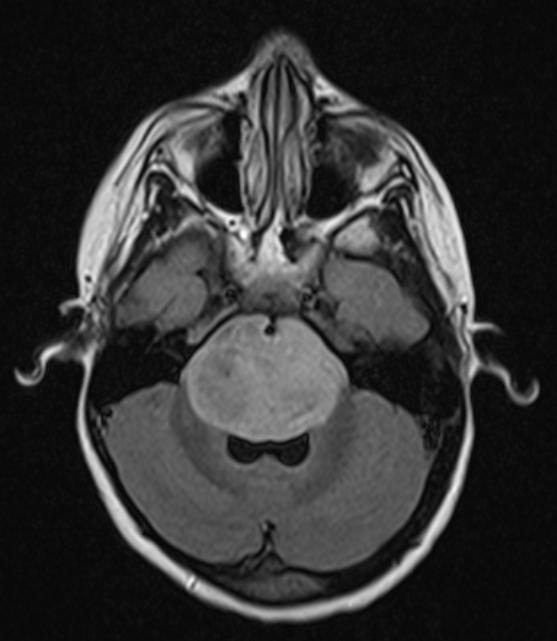

In [24]:
# how an image looks
I = np.asarray(PIL.Image.open("dataset/Testing/glioma_tumor/image(2).jpg"))
im = PIL.Image.fromarray(np.uint8(I))
im

In [25]:
I.shape # see the dimensions of the image here

(641, 557, 3)

In [26]:
# define parameters for Keras to load data into variables; compresses images
image_size = (150, 150)
img_height = 150
img_width = 150
batch_size = 32

Now, we will import the images into Keras. Keras will allow us to quickly differentiate between training and testing data.

In [27]:
# create the datasets using Keras DataSet object
import tensorflow as tf 
from tensorflow import keras

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Training/",
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Testing/",
    image_size=image_size,
    batch_size=batch_size,
)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [56]:
im_classes = {
  0 : 'Glioma',
  1 : 'Meningioma',
  2 : 'No Tumor',
  3 : 'Pituitary',
}
class_labels = list(im_classes.values())
num_classes = len(class_labels)

## Step 3: Exploratory Data Analysis

We will first look inside the **training dataset** and walk through it.

In [29]:
# EDA - look at proportion of each class inside the training dataset
import os 

images_per_class_training = {}
for folder in os.listdir("dataset/Training"):
  images_per_class_training[folder] = len(os.listdir(f'dataset/Training/{folder}')) # get the size of each folder (ie how many images there are in each)

print(images_per_class_training)

{'meningioma_tumor': 822, 'pituitary_tumor': 827, 'no_tumor': 395, 'glioma_tumor': 826}


We want each type of image to have roughly the same weightage in terms of number of them in the total dataset. Let's check the proportions.

In [32]:
dataset_size = sum(images_per_class_training.values())

for key, index in images_per_class_training.items():
  images_per_class_training[key] = round(images_per_class_training[key] / dataset_size,3)

print(images_per_class_training)

{'meningioma_tumor': 0.286, 'pituitary_tumor': 0.288, 'no_tumor': 0.138, 'glioma_tumor': 0.288}


Let's see a visualization of the proportions:

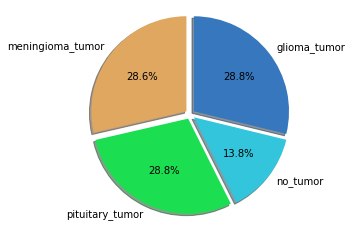

In [35]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = images_per_class_training.keys()
sizes = images_per_class_training.values()
explode = (0.05, 0.05, 0.05, 0.05) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=['#e0a760','#1bde50','#32c5db','#3777bd'], 
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Hmm... these proportions don't look even. In the future, to enhance this model, we would want to add more no_tumor images.

We will now look inside the **testing dataset** and walk through it.

In [36]:
# EDA - look at proportion of each class inside the testing dataset

images_per_class_testing = {}
for folder in os.listdir("dataset/Testing"):
  images_per_class_testing[folder] = len(os.listdir(f'dataset/Testing/{folder}'))

print(images_per_class_testing)

{'meningioma_tumor': 115, 'pituitary_tumor': 74, 'no_tumor': 105, 'glioma_tumor': 100}


Let's see a visualization of the proportions:

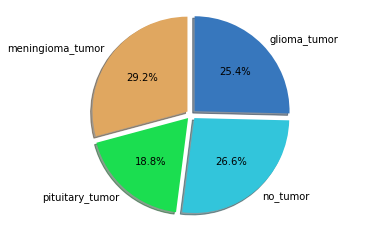

In [37]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = images_per_class_testing.keys()
sizes = images_per_class_testing.values()
explode = (0.05, 0.05, 0.05, 0.05) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=['#e0a760','#1bde50','#32c5db','#3777bd'], 
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

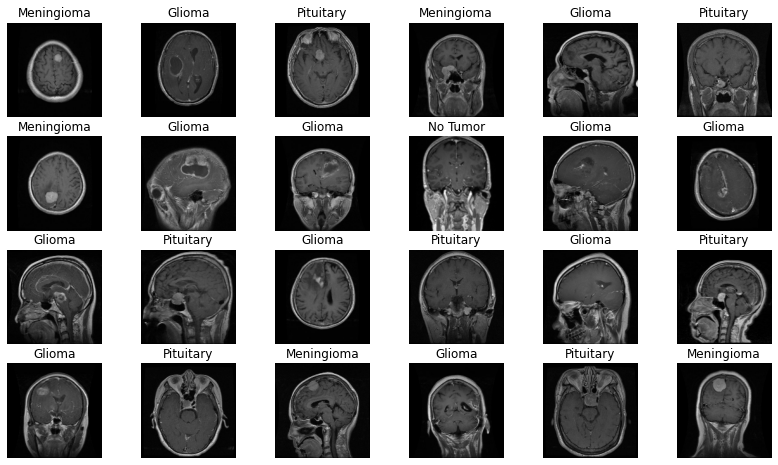

In [58]:
# EDA - randomly sampling 9 images across all the categories
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for images, labels in train_ds.take(1):
    
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(im_classes[int(labels[i])])
        plt.axis("off")

## Step 4: Modeling

Kick off the machine learning and start training the model.

In [39]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [40]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam', # adam is best optimizer (highest accuracy)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

Time to start training! Note: make sure Runtime type is set to GPU for increased speed.

In [43]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/10
90/90 [==============================] - 38s 66ms/step - loss: 0.8399 - accuracy: 0.6449 - val_loss: 2.1271 - val_accuracy: 0.4619
Epoch 2/10
90/90 [==============================] - 6s 61ms/step - loss: 0.4412 - accuracy: 0.8261 - val_loss: 2.1331 - val_accuracy: 0.5888
Epoch 3/10
90/90 [==============================] - 6s 63ms/step - loss: 0.2570 - accuracy: 0.9017 - val_loss: 2.4205 - val_accuracy: 0.6320
Epoch 4/10
90/90 [==============================] - 6s 62ms/step - loss: 0.1318 - accuracy: 0.9526 - val_loss: 3.1171 - val_accuracy: 0.6421
Epoch 5/10
90/90 [==============================] - 6s 63ms/step - loss: 0.0812 - accuracy: 0.9697 - val_loss: 4.2778 - val_accuracy: 0.6904
Epoch 6/10
90/90 [==============================] - 6s 63ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 3.6651 - val_accuracy: 0.7665
Epoch 7/10
90/90 [==============================] - 6s 68ms/step - loss: 0.0350 - accuracy: 0.9902 - val_loss: 4.2136 - val_accuracy: 0.7360
Epoch 8/10
9

By the end, we have a ~99% training accuracy (images the model has seen) and a ~73% testing data accuracy (images the model has never seen these before). 

Now, we want to see which tumor types are reducing accuracy and why.

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

def get_preds_and_trues(model_used, ds): # compares predicted values to true values
  trues = []
  preds = []
  for input, labels in ds:
    batch_predictions = model_used.predict(x=input)
    for pred in batch_predictions:
      preds.append(np.argmax(tf.nn.softmax(pred)))
    for label in labels:
      trues.append(int(label))
  return trues, preds # returns tuple with 2 lists in it

In [46]:
def get_confusion_df(model, val_ds):
  # column is what it actually is, row is prediction
  # labels running on top is predicted
  # labels running on side is actual

  trues, preds = get_preds_and_trues(model, val_ds)
  confusion = confusion_matrix(y_true = trues, y_pred = preds)
  confusion_df = pd.DataFrame(confusion, index = class_labels, columns = class_labels)
  
  return confusion_df # returns a dataframe for comparison purposes

In [53]:
def plot_heamtmap(confusion_matrix, name): 
  # figure
  fig, ax = plt.subplots(figsize=(11, 9))

  # plot heatmap
  sns.heatmap(confusion_matrix, annot = True, cmap="Blues", vmin= 0, vmax=120, 
              square=True, linewidth=0.8, fmt='g', 
              xticklabels=class_labels, yticklabels=class_labels,
              annot_kws={'fontsize':15})
  # xticks
  ax.xaxis.tick_top()

  # axis labels
  plt.xlabel('PREDICTED')
  plt.ylabel('ACTUAL')

  # title
  title = f'{name} Performance\n'.upper()
  plt.title(title, loc='left')
  plt.show()

Read heatmap:

*   We want diagonal to be dark
*   Vertical categories (y-axis) are what the images should be
*   Horizontal categories (x-axis) are how many of the specific tumor the model classified as other tumors


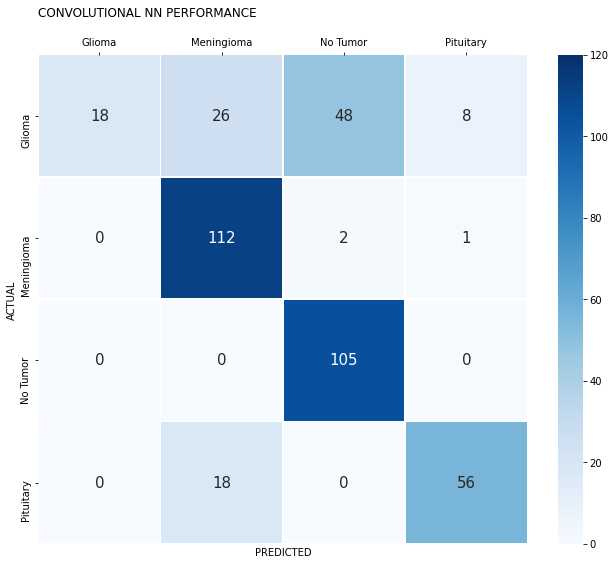

In [57]:
cnn_df = get_confusion_df(model, test_ds)
plot_heamtmap(cnn_df, 'Convolutional NN')